# **App Rating & Sentiment Prediction**

## **Introduction**

The goal of this project is to use data of 10k Play Store apps and their user reviews to make rating & sentiment predictions.
The dataset is composed of two *csv* files :
*   *googleplaystore_user_reviews.csv* : contains the first 'most relevant' 100 reviews for each app
*   *googleplaystore.csv* : contains the details of the apps

We start by loading some libraries and importing the dataset.

In [0]:
from sklearn.linear_model import LinearRegression 
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec
from scipy import spatial
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
app_data_file_name = 'googleplaystore.csv'
user_reviews_file_name = 'googleplaystore_user_reviews.csv'

In [0]:
app_data = pd.read_csv(app_data_file_name)
user_reviews = pd.read_csv(user_reviews_file_name)

## **I. Data Exploration**

In this section we will be discovering our data, we will look at some of its relevant properties, like the size, the type ... 

### **I. 1. Details of the apps**


In [100]:
print("We have", app_data.shape[0], "apps, and", app_data.shape[1], "features for each app.")

We have 10841 apps, and 13 features for each app.


In [101]:
print("These are the features: \n", app_data.columns)

These are the features: 
 Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')


Here is what the dataset looks like. \\
We can see that most of the fields do not have numerical value: we will take care of that in the data cleaning section.


In [102]:
app_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [103]:
app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [104]:
app_data.describe(include = 'all')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841,10841,9367.000000,10841,10841,10841,10840,10841,10840,10841,10841,10833,10838
unique,9660,34,NaN,6002,462,22,3,93,6,120,1378,2832,33
top,ROBLOX,FAMILY,NaN,0,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,9,1972,NaN,596,1695,1579,10039,10040,8714,842,326,1459,2451
mean,NaN,NaN,4.193338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.537431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For a total of 10841 apps, we only have 9367 rated apps: we need to scale down our research to the rated portion of the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1237625c88>]],
      dtype=object)

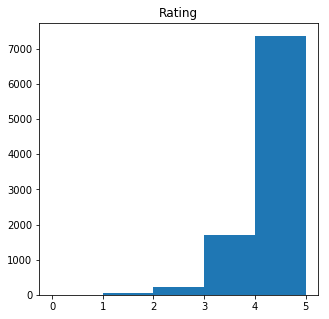

In [105]:
app_data.hist(bins = 5, column = "Rating", figsize=(5, 5), grid = False, range=(0, 5))

### **I. 2. User reviews**

In [106]:
user_reviews.shape

(64295, 5)

In [107]:
user_reviews.columns

Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'],
      dtype='object')

In [108]:
user_reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [109]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
App                       64295 non-null object
Translated_Review         37427 non-null object
Sentiment                 37432 non-null object
Sentiment_Polarity        37432 non-null float64
Sentiment_Subjectivity    37432 non-null float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [110]:
user_reviews.describe(include = 'all')

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
count,64295,37427,37432,37432.000000,37432.000000
unique,1074,27994,3,NaN,NaN
top,"CBS Sports App - Scores, News, Stats & Watch Live",Good,Positive,NaN,NaN
freq,320,247,23998,NaN,NaN
mean,NaN,NaN,NaN,0.182146,0.492704
std,NaN,NaN,NaN,0.351301,0.259949
min,NaN,NaN,NaN,-1.000000,0.000000
25%,NaN,NaN,NaN,0.000000,0.357143
50%,NaN,NaN,NaN,0.150000,0.514286
75%,NaN,NaN,NaN,0.400000,0.650000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12375e0e10>,
      dtype=object)

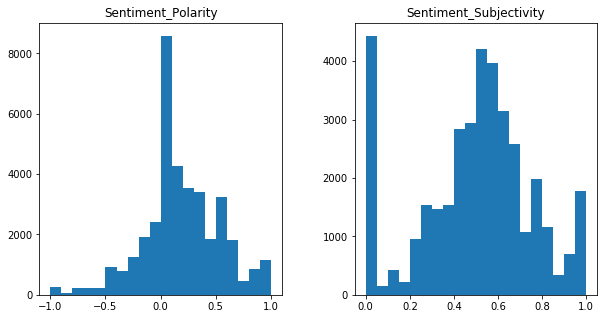

In [111]:
user_reviews.hist(bins = 20, column = ['Sentiment_Polarity', 'Sentiment_Subjectivity'], figsize = (10, 5), grid = False)

## **II. Data Cleaning**

Here are some functions we'll use to clean the data and convert all the string values into intergers.

In [0]:
def commas_to_int(commas):
  L = [c for c in commas if c!=',']
  string = ''.join(L)
  return int(string)

def string_to_int(s):
  if s[-1]=='M':
    n = float(s[:-1])*1000000
  elif s[-1]=='K' or s[-1]=='k':
    n = float(s[:-1])*1000
  elif s[-1]=='+':
    n = commas_to_int(s[:-1])
  elif s[0] == "$":
    n = float(s[1:])*100
  else:
    n = float(s)
  return int(n)

def type_to_binary(t):
  if t == "Free":
    return 0
  else :
    return 1
  
def CR_to_int(list_of_ratings):
  list_of_ratings = list(list_of_ratings)
  return lambda rating : len(list_of_ratings) - list_of_ratings.index(rating) - 1 

### II. 1. Dropping unecessary colums

Since we can assume that the *Android Ver*, *Current Ver* and *Last Updated* columns are unrelated to the rating property, we can drop them from our data set.

In [113]:
app_data.drop(labels = ['Last Updated','Current Ver','Android Ver'], axis = 1, inplace = True)
app_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity


### II.2 Removing Rows with NaN values

In [114]:
previous_number_of_rows = app_data.shape[0]
app_data = app_data.dropna()
print("New shape =", app_data.shape)
print('Ratio of deleted rows:', round((1-app_data.shape[0]/previous_number_of_rows)*100), '%')

New shape = (9366, 10)
Ratio of deleted rows: 14 %


In [115]:
previous_number_of_rows = user_reviews.shape[0]
user_reviews = user_reviews.dropna()
print("New shape =", user_reviews.shape)
print('Ratio of deleted rows:', round((1-user_reviews.shape[0]/previous_number_of_rows)*100), '%')

New shape = (37427, 5)
Ratio of deleted rows: 42 %


### II. 3. Changing fields with numerical nature to numbers



#### a) REVIEWS

In [116]:
app_data['Reviews'].unique()

array(['159', '967', '87510', ..., '603', '1195', '398307'], dtype=object)

Since we only have integer values, we can directly convert the reviews into integers (they are currently strings).

In [117]:
app_data['Reviews'] = app_data['Reviews'].apply(string_to_int)
app_data['Reviews'].unique()

array([   159,    967,  87510, ...,    603,   1195, 398307])

#### b) SIZE

In [118]:
app_data['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M',
       '11M', '24M', 'Varies with device', '9.4M', '15M', '10M', '1.2M',
       '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k', '3.6M',
       '5.7M', '8.6M', '2.4M', '27M', '2.5M', '7.0M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '22M', '6.4M', '3.2M', '8.2M', '4.9M', '9.5M', '5.0M',
       '5.9M', '13M', '73M', '6.8M', '3.5M', '4.0M', '2.3M', '2.1M',
       '42M', '9.1M', '55M', '23k', '7.3M', '6.5M', '1.5M', '7.5M', '51M',
       '41M', '48M', '8.5M', '46M', '8.3M', '4.3M', '4.7M', '3.3M', '40M',
       '7.8M', '8.8M', '6.6M', '5.1M', '61M', '66M', '79k', '8.4M',
       '3.7M', '118k', '44M', '695k', '1.6M', '6.2M', '53M', '1.4M',
      

We need to scale all the sizes to the same unit, and get rid of the 'M' or 'K' and of course remove rows that have 'Varies with device'.

In [119]:
app_data = app_data[app_data.Size != 'Varies with device']
app_data['Size'] = app_data['Size'].apply(string_to_int)
app_data['Size'].unique()

array([ 19000000,  14000000,   8700000,  25000000,   2800000,   5600000,
        29000000,  33000000,   3100000,  28000000,  12000000,  20000000,
        21000000,  37000000,   2700000,   5500000,  17000000,  39000000,
        31000000,   4200000,  23000000,   6000000,   6100000,   4600000,
         9200000,   5200000,  11000000,  24000000,   9400000,  15000000,
        10000000,   1200000,  26000000,   8000000,   7900000,  56000000,
        57000000,  35000000,  54000000,    201000,   3600000,   5700000,
         8600000,   2400000,  27000000,   2500000,   7000000,  16000000,
         3400000,   8900000,   3900000,   2900000,  38000000,  32000000,
         5400000,  18000000,   1100000,   2200000,   4500000,   9800000,
        52000000,   9000000,   6700000,  30000000,   2600000,   7100000,
        22000000,   6400000,   3200000,   8199999,   4900000,   9500000,
         5000000,   5900000,  13000000,  73000000,   6800000,   3500000,
         4000000,   2300000,   2100000,  42000000, 

#### c) INSTALLS

In [120]:
app_data['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000+', '500,000,000+', '100+', '500+', '10+', '1,000,000,000+',
       '5+', '50+', '1+'], dtype=object)

Here we need to remove the "+".

In [121]:
app_data['Installs'] = app_data['Installs'].apply(string_to_int)
app_data['Installs'].unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
             1000,  500000000,        100,        500,         10,
       1000000000,          5,         50,          1])

#### d) PRICE

In [122]:
app_data['Price'].unique()

array(['0', '$4.99', '$6.99', '$7.99', '$3.99', '$5.99', '$2.99', '$1.99',
       '$9.99', '$0.99', '$9.00', '$5.49', '$10.00', '$24.99', '$11.99',
       '$79.99', '$16.99', '$14.99', '$29.99', '$12.99', '$3.49',
       '$10.99', '$7.49', '$1.50', '$19.99', '$15.99', '$33.99', '$39.99',
       '$2.49', '$4.49', '$1.70', '$1.49', '$3.88', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$1.59',
       '$6.49', '$1.29', '$299.99', '$379.99', '$37.99', '$18.99',
       '$389.99', '$8.49', '$1.75', '$14.00', '$2.00', '$3.08', '$2.59',
       '$19.40', '$15.46', '$8.99', '$3.04', '$13.99', '$4.29', '$3.28',
       '$4.60', '$1.00', '$2.90', '$1.97', '$2.56', '$1.20'], dtype=object)

We have to remove the "$" sign and convert the prices into cents in order to work with integer values.

In [123]:
app_data['Price'] = app_data['Price'].apply(string_to_int)
app_data['Price'].unique()

array([    0,   499,   699,   799,   399,   599,   299,   199,   999,
          99,   900,   549,  1000,  2499,  1199,  7998,  1698,  1499,
        2999,  1299,   349,  1099,   749,   150,  1998,  1599,  3399,
        3999,   249,   449,   170,   149,   388, 39999,  1798, 40000,
         302,   176,   484,   476,   161,   159,   649,   129, 29999,
       37999,  3799,  1898, 38999,   849,   175,  1400,   200,   308,
         259,  1939,  1546,   899,   304,  1399,   429,   328,   459,
         100,   290,   197,   256,   120])

### II. 4. Changing fields with non numerical nature to numbers

#### a) TYPE

In [124]:
app_data['Type'].unique()

array(['Free', 'Paid'], dtype=object)

We can convert the *Type* column into a binary $0/1$ column since it contains either 'Free' or 'Paid' tags.

In [125]:
app_data['Type'] = app_data['Type'].apply(type_to_binary)
app_data['Type'].unique()

array([0, 1])

#### b) CONTENT RATING

In [126]:
app_data['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

For the content rating, we can give an integer order to the tags. For example, *Unrated* $= 0$, ..., *Everyone* $= 5$.

In [127]:
app_data['Content Rating'] = app_data['Content Rating'].apply(CR_to_int(app_data['Content Rating'].unique()))
app_data['Content Rating'].unique()

array([5, 4, 3, 2, 1, 0])

#### c) CATEGORY

In [128]:
app_data['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

Since we can't order the categories, it's not recommanded to transform this field into an integer field. \\
Instead, we create dummy columns to represent each category. 

In [129]:
app_data = pd.get_dummies(app_data, columns=['Category'])
app_data.head(2)

,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19000000,10000,0,0,5,Art & Design,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14000000,500000,0,0,5,Art & Design;Pretend Play,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### d) GENRES

In [130]:
app_data['Genres'].unique()


array(['Art & Design', 'Art & Design;Pretend Play',
       'Art & Design;Creativity', 'Auto & Vehicles', 'Beauty',
       'Books & Reference', 'Business', 'Comics', 'Comics;Creativity',
       'Communication', 'Dating', 'Education', 'Education;Creativity',
       'Education;Education', 'Education;Action & Adventure',
       'Education;Pretend Play', 'Education;Brain Games', 'Entertainment',
       'Entertainment;Brain Games', 'Entertainment;Music & Video',
       'Events', 'Finance', 'Food & Drink', 'Health & Fitness',
       'House & Home', 'Libraries & Demo', 'Lifestyle',
       'Lifestyle;Pretend Play', 'Adventure;Action & Adventure', 'Arcade',
       'Casual', 'Card', 'Casual;Pretend Play', 'Strategy', 'Action',
       'Puzzle', 'Sports', 'Word', 'Racing', 'Casual;Creativity',
       'Simulation', 'Adventure', 'Board', 'Trivia', 'Role Playing',
       'Simulation;Education', 'Action;Action & Adventure',
       'Casual;Brain Games', 'Simulation;Action & Adventure',
       'Education

We can make dummy columns for this field too.

In [131]:
app_data = pd.get_dummies(app_data, columns=['Genres'])
app_data.head(2)

,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,...,Genres_Parenting,Genres_Parenting;Brain Games,Genres_Parenting;Education,Genres_Parenting;Music & Video,Genres_Personalization,Genres_Photography,Genres_Productivity,Genres_Puzzle,Genres_Puzzle;Action & Adventure,Genres_Puzzle;Brain Games,Genres_Puzzle;Creativity,Genres_Puzzle;Education,Genres_Racing,Genres_Racing;Action & Adventure,Genres_Racing;Pretend Play,Genres_Role Playing,Genres_Role Playing;Action & Adventure,Genres_Role Playing;Brain Games,Genres_Role Playing;Pretend Play,Genres_Shopping,Genres_Simulation,Genres_Simulation;Action & Adventure,Genres_Simulation;Education,Genres_Simulation;Pretend Play,Genres_Social,Genres_Sports,Genres_Sports;Action & Adventure,Genres_Strategy,Genres_Strategy;Action & Adventure,Genres_Strategy;Creativity,Genres_Strategy;Education,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19000000,10000,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14000000,500000,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### II. 5. Reuniting the two datasets

#### a) SENTIMENT

The most important feature in the user reviews table is the sentiment.

In [132]:
user_reviews['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

First, we need to transform it into an integer field : *Positive* $= 2$, *Neutral* $= 1$ and *Negative* $= 0$.

In [133]:
user_reviews['Sentiment'] = user_reviews['Sentiment'].apply(CR_to_int(user_reviews['Sentiment'].unique()))
user_reviews['Sentiment'].unique()

array([2, 1, 0])

#### b) Can we add the Sentiment average to the app's table?

In [134]:
A = app_data['App'].unique()
B = user_reviews['App'].unique()
C = [] 
for b in B:
    if b in A :
        C.append(b)

print("We have", len(A), "apps in our data set.")                
print("There are", len(B), "apps reviewed.")
print("There are", len(C), "reviewed apps in our data set.")

We have 7029 apps in our data set.
There are 865 apps reviewed.
There are 569 reviewed apps in our data set.


Since the number of reviewed app is very small compared to the size of our data set, *user_reviews* table does not provide relevant information to be added to *app_data* table

### II. 6. Scaling data

This makes training less sensitive to the scale of features.

In [135]:
app_data.columns[1:]


Index(['Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       ...
       'Genres_Strategy;Education', 'Genres_Tools', 'Genres_Travel & Local',
       'Genres_Travel & Local;Action & Adventure', 'Genres_Trivia',
       'Genres_Video Players & Editors',
       'Genres_Video Players & Editors;Creativity',
       'Genres_Video Players & Editors;Music & Video', 'Genres_Weather',
       'Genres_Word'],
      dtype='object', length=152)

In [0]:
app_data_final_array = normalize(np.array(app_data)[:,1:], axis = 0, norm = 'max')

In [0]:
app_data_final_df = pd.DataFrame(data = app_data_final_array, columns = app_data.columns[1:] )

In [138]:
app_data_final_df.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,...,Genres_Parenting,Genres_Parenting;Brain Games,Genres_Parenting;Education,Genres_Parenting;Music & Video,Genres_Personalization,Genres_Photography,Genres_Productivity,Genres_Puzzle,Genres_Puzzle;Action & Adventure,Genres_Puzzle;Brain Games,Genres_Puzzle;Creativity,Genres_Puzzle;Education,Genres_Racing,Genres_Racing;Action & Adventure,Genres_Racing;Pretend Play,Genres_Role Playing,Genres_Role Playing;Action & Adventure,Genres_Role Playing;Brain Games,Genres_Role Playing;Pretend Play,Genres_Shopping,Genres_Simulation,Genres_Simulation;Action & Adventure,Genres_Simulation;Education,Genres_Simulation;Pretend Play,Genres_Social,Genres_Sports,Genres_Sports;Action & Adventure,Genres_Strategy,Genres_Strategy;Action & Adventure,Genres_Strategy;Creativity,Genres_Strategy;Education,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,0.82,0.000004,0.190,0.00001,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.78,0.000022,0.140,0.00050,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.94,0.001949,0.087,0.00500,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.90,0.004803,0.250,0.05000,0.0,0.0,0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.86,0.000022,0.028,0.00010,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **III. Machine Learning Models**

Once the data is cleaned, we can start to apply ML models to it in order to make rating predictions.
Here are some functions we will use to build our models and evaluate their performance. 

In [0]:
X = app_data_final_df.drop(labels = ['Rating'], axis = 1)
y = app_data_final_df['Rating']

### **III. 0.  Dimensionality reduction**

Since we have a very sparse data set, it is a good idea to get rid of the unnecessary information

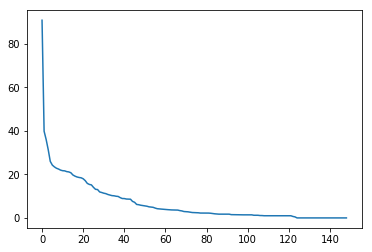

In [140]:
svd = TruncatedSVD(n_components=X.shape[1]-2)
svd.fit(X)
plt.plot(svd.singular_values_)

We can  set the new number components to $n = 60$ based on the graph above, the singular values are a lot closer to $0$ starting from the $60^{th}$ value. 

In [0]:
svd = TruncatedSVD(n_components=60)
X = svd.fit_transform(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

def model_results(model):
  model.fit(X_train, y_train)
  return model.predict(X_test)
  

def display_errors(test, results):
  print('MSE:', round(metrics.mean_squared_error(test, results),4))
  print('MAE:', round(metrics.mean_absolute_error(test, results),4))
  print('MSLE:', round(metrics.mean_squared_log_error(test, results),4))
  print('Predictions mean:', round(results.mean(),4))
  print('Real mean:', round(y_test.mean(),4))
  print('Relative gap:', round(abs(results.mean()-y_test.mean())/abs(y_test.mean())*100,2), '%')  
  
def plot_results(test, results, title):  
  plt.figure()
  sns.regplot(results, test)
  plt.title(title)
  plt.xlabel('Predicted Ratings')
  plt.ylabel('Actual Ratings')
  plt.show()

### **III. 1. Linear Regression Model**


In [0]:
LR_model = LinearRegression()
LR_results = model_results(LR_model)

In [144]:
display_errors(y_test, LR_results)

MSE: 0.0114
MAE: 0.0755
MSLE: 0.0039
Predictions mean: 0.8354
Real mean: 0.8352
Relative gap: 0.02 %


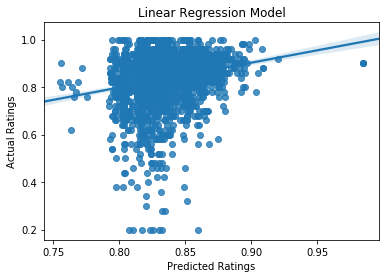

In [145]:
plot_results(y_test, LR_results, title = 'Linear Regression Model')

### **III. 2. Support Vector Regresion Model** 


#### a) Linear

In [146]:
SVRL_model = svm.SVR(C=1e2, kernel='linear', gamma = 'auto')
SVRL_results = model_results(SVRL_model)
display_errors(y_test, SVRL_results)

MSE: 0.0116
MAE: 0.077
MSLE: 0.0039
Predictions mean: 0.8305
Real mean: 0.8352
Relative gap: 0.56 %


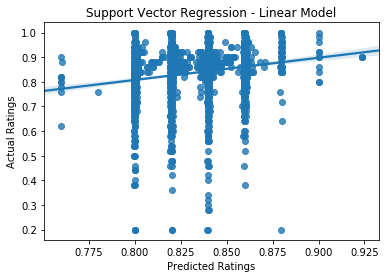

In [147]:
plot_results(y_test, SVRL_results, title = 'Support Vector Regression - Linear Model')

#### b) Polynomial

In [148]:
SVRP_model = svm.SVR(C=1e2, kernel='poly', degree = 3, gamma = 'auto')
SVRP_results = model_results(SVRP_model)
display_errors(y_test, SVRP_results)

MSE: 0.0116
MAE: 0.0775
MSLE: 0.004
Predictions mean: 0.8294
Real mean: 0.8352
Relative gap: 0.69 %


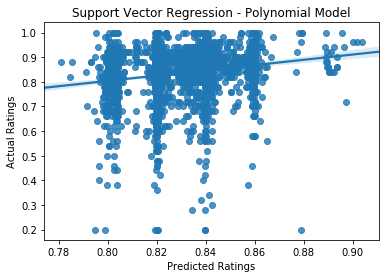

In [149]:
plot_results(y_test, SVRP_results, title = 'Support Vector Regression - Polynomial Model')

#### c) Radial basis function

In [150]:
SVRB_model = svm.SVR(C=1e2, kernel='rbf', gamma = 'auto')
SVRB_results = model_results(SVRB_model)
display_errors(y_test, SVRB_results)

MSE: 0.0116
MAE: 0.0771
MSLE: 0.004
Predictions mean: 0.8305
Real mean: 0.8352
Relative gap: 0.56 %


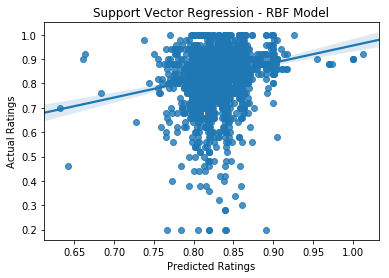

In [151]:
plot_results(y_test, SVRB_results, title = 'Support Vector Regression - RBF Model')

### **III. 3. Decision Tree Regressor Model**


In [0]:
DTR_model = DecisionTreeRegressor()
DTR_results = model_results(DTR_model)

In [153]:
display_errors(y_test, DTR_results)

MSE: 0.0207
MAE: 0.0934
MSLE: 0.0071
Predictions mean: 0.8331
Real mean: 0.8352
Relative gap: 0.25 %


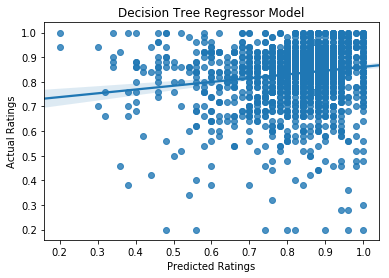

In [154]:
plot_results(y_test, DTR_results, title = 'Decision Tree Regressor Model')

### **III. 4. Random Forest Regressor Model**


In [0]:
RFR_model = RandomForestRegressor(n_estimators = 100)
RFR_results = model_results(RFR_model)

In [156]:
display_errors(y_test, RFR_results)

MSE: 0.0133
MAE: 0.0777
MSLE: 0.0045
Predictions mean: 0.8334
Real mean: 0.8352
Relative gap: 0.21 %


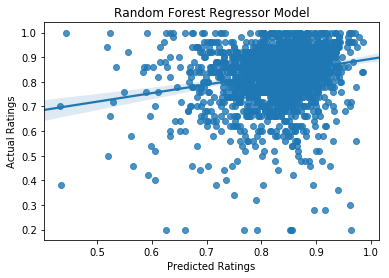

In [157]:
plot_results(y_test, RFR_results, title = 'Random Forest Regressor Model')

#### **What are the relevant features ?**


The RFR model has the advantage of allowing us to visualize the importance of each feature. Let's take this opportunity to check that we deal with useful features. Are the categories and the genres really relevant in rating prediction? 

<Figure size 1080x1080 with 0 Axes>

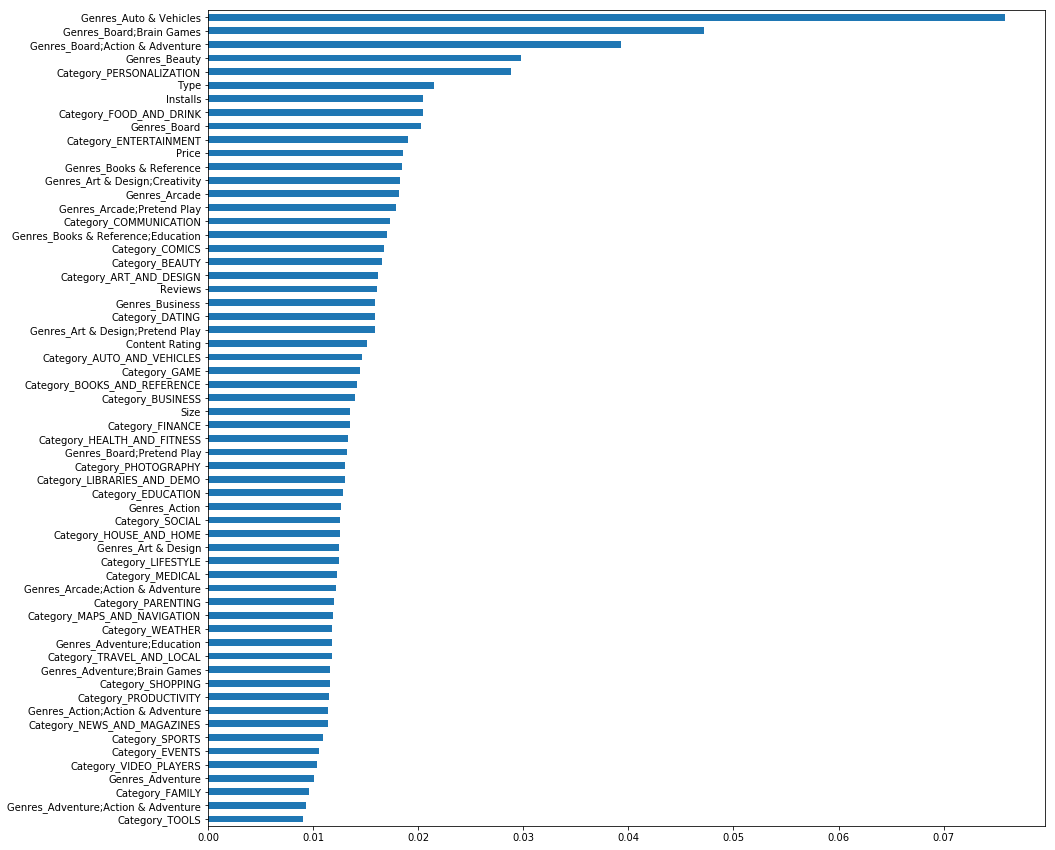

In [158]:
features_importance = {}
for column, feature in zip(app_data_final_df.drop(labels = ['Rating'], axis = 1).columns, RFR_model.feature_importances_):
    features_importance[column] = feature

features_importance = pd.DataFrame.from_dict(features_importance,orient = 'index')
features_importance.sort_values(by = 0, inplace = True)
features_importance.rename(index = str, columns = {0:'Pct'}, inplace = True)

plt.figure(figsize= (15,15))
features_importance.plot(kind = 'barh', figsize= (15,15),legend = False)
plt.show()

The figure above points the importance of taking into account the category, and especially the genre of an app. 

### III. 5. Artificial Neural Network

In [159]:
# Initialising the ANN
ANN_model = Sequential()
    
# Adding the input layer and the first hidden layer
ANN_model.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
ANN_model.add(Dropout(p = 0.1))
    
#Adding the second hidden layer
ANN_model.add(Dense(units =  80, kernel_initializer = 'uniform', activation = 'relu'))
    
# Adding the third hidden layer
ANN_model.add(Dense(units =  60, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the 4th  hidden layer
ANN_model.add(Dense(units =  20, kernel_initializer = 'uniform', activation = 'relu'))
ANN_model.add(Dropout(p = 0.1))
    
# Adding the output layer
ANN_model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
    
# Compiling the ANN
ANN_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
# Fitting the ANN to the Training set
ANN_model.fit(X_train, y_train, batch_size = 10, epochs = 50)

ANN_results = ANN_model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  from ipykernel import kernelapp as app


Epoch 1/50
5410/5410 [==============================] - 1s 263us/step - loss: 0.0678
Epoch 2/50
5410/5410 [==============================] - 1s 164us/step - loss: 0.0219
Epoch 3/50
5410/5410 [==============================] - 1s 164us/step - loss: 0.0202
Epoch 4/50
5410/5410 [==============================] - 1s 183us/step - loss: 0.0177
Epoch 5/50
5410/5410 [==============================] - 1s 160us/step - loss: 0.0167
Epoch 6/50
5410/5410 [==============================] - 1s 164us/step - loss: 0.0151
Epoch 7/50
5410/5410 [==============================] - 1s 159us/step - loss: 0.0140
Epoch 8/50
5410/5410 [==============================] - 1s 163us/step - loss: 0.0134
Epoch 9/50
5410/5410 [==============================] - 1s 165us/step - loss: 0.0127
Epoch 10/50
5410/5410 [==============================] - 1s 161us/step - loss: 0.0121
Epoch 11/50
5410/5410 [==============================] - 1s 163us/step - loss: 0.0120
Epoch 12/50
5410/5410 [==============================] - 1s 175

In [160]:
display_errors(y_test, ANN_results)

MSE: 0.0113
MAE: 0.0751
MSLE: 0.0039
Predictions mean: 0.8334
Real mean: 0.8352
Relative gap: 0.21 %


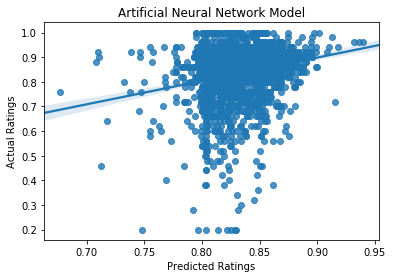

In [161]:
plot_results(y_test, ANN_results, title = 'Artificial Neural Network Model')

### **III. 6. Sentiment classifier**

Here, we want to use the *user_reviews* table to build a classifier that predicts the sentiment (*Positive*, *Neutral* or *Negative*) of a review. \\
Two ideas are presented below.

#### III. 6. 1. Using Word2Vec

A first idea is to use the word embedding model Word2Vec. \\
Word2vec is a two-layer neural network that allows, once well trained, to extract vectorial features from each word (that feature is supposed to depict the context, the meaning of the word). A Word2vec is trained by feeding it with a large corpus of sentences. We had the idea to try to train a Word2Vec model with the reviews. 

We start by removing stopwords (non-meaningful words, such as *a*, *the*, *me*, etc.) and tokenize each review (convert the string into a list of words).

In [164]:
nltk.download('punkt')
nltk.download('stopwords')

def tokenize(review):
  review_without_punctuation = review.translate(str.maketrans('', '', string.punctuation))
  tokenized_review = review_without_punctuation.split(' ')
  tokenized_review = [word for word in tokenized_review if word not in stopwords.words('english')]
  return tokenized_review

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
corpus = user_reviews['Translated_Review'].apply(tokenize)

In [166]:
corpus.head()

0    [I, like, eat, delicious, food, Thats, Im, coo...
1    [This, help, eating, healthy, exercise, regula...
3    [Works, great, especially, going, grocery, store]
4                                     [Best, idea, us]
5                                          [Best, way]
Name: Translated_Review, dtype: object

In [0]:
W2V_model = Word2Vec(corpus)
index2word_set = set(W2V_model.wv.index2word)

Since Word2Vec only works on words and not on full sentences, the following function returns the average feature vector of a sentence. 

In [0]:
def avg_feature_vector(sentence, model = W2V_model, num_features = 100, index2word_set = index2word_set): 
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [169]:
X2 = [avg_feature_vector(review) for review in user_reviews['Translated_Review']]    
y2 = user_reviews['Sentiment']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
def model_results2(model):
  model.fit(X2_train, y2_train)
  return model.predict(X2_test)

def display_accuracy(model):
  print('Accuracy:', round(model.score(X2_test, y2_test)*100, 2), '%')  

##### a) Logistic Regression

In [174]:
LGR_model = LogisticRegression()
LGR_results = model_results2(LGR_model)
display_accuracy(LGR_model)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 70.65 %


##### b) Decision Tree Classifier

In [175]:
DTC_model = DecisionTreeClassifier()
DTC_results = model_results2(DTC_model)
display_accuracy(DTC_model)

Accuracy: 73.37 %


##### c) K-Nearest Neighbors

In [176]:
KNN_model = KNeighborsClassifier()
KNN_results = model_results2(KNN_model)
display_accuracy(KNN_model)

Accuracy: 70.63 %


##### d) Linear Discriminant Analysis

In [177]:
LDA_model = LinearDiscriminantAnalysis()
LDA_results = model_results2(LDA_model)
display_accuracy(LDA_model)

Accuracy: 70.47 %


##### e) Gaussian Naive Bayes

In [178]:
GNB_model = GaussianNB()
GNB_results = model_results2(GNB_model)
display_accuracy(GNB_model)

Accuracy: 51.22 %


##### f) Support Vector Machine 

This model is too slow to be tested.

In [0]:
#SVM_model = SVC()
#SVM_results = model_results2(SVM_model)
#display_accuracy(SVM_model) 

##### g) AdaBoost Classifier 

In [180]:
AC_model = AdaBoostClassifier()
AC_results = model_results2(AC_model)
display_accuracy(AC_model)

Accuracy: 69.15 %


As we can see by looking at the accuracy of each model, that approach is a bit disappointing. \\
That results might be explained by two factors :
*   the quality of the data: the data is pretty noisy and would have deserved a deeper cleaning (using regular expressions for example)
*  taking the average feature vector makes us lose information and makes inaccurate the features. An improvement would be to use Doc2Vec, instead of Word2Vec: it is its generalization to text embedding. 



#### III. 6. 2. Using sklearn et keras

In [0]:
X3 = user_reviews['Translated_Review']
y3 = user_reviews['Sentiment']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)

In [0]:
vectorizer = CountVectorizer()

vectorizer.fit(X3)
X3_train = vectorizer.transform(X3_train)
X3_test = vectorizer.transform(X3_test)

In [184]:
S_model = Sequential()
S_model.add(Dense(units = 100, activation = 'relu', input_dim = len(vectorizer.get_feature_names())))
S_model.add(Dense(units = 3, activation = 'sigmoid'))
S_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = S_model.fit(X3_train, y3_train, epochs = 2, verbose = 1)
scores = S_model.evaluate(X3_test, y3_test, verbose = 1)
print("Accuracy:", round(scores[1]*100, 2), '%')

Epoch 1/2
26198/26198 [==============================] - 48s 2ms/step - loss: 0.4470 - acc: 0.8320
Epoch 2/2
11229/11229 [==============================] - 4s 342us/step
Accuracy: 92.33 %


### **III. 7. Adding the name of the app?**


Another idea would be to keep the name of the apps in the features of the app rating models (by converting them using Word2Vec or CountVectorizer). 

## IV. Conclusion

In this section, we will compare the Machine Learning models, based on their score.

### IV. 1.  Rating Prediction Models

In [0]:
Names = ['LR', 'SVM-L', 'SVM-P', 'SVM-RBF', 'DT', 'RF', 'ANN']
Results = [LR_results, SVRL_results, SVRP_results, SVRB_results, DTR_results, RFR_results, ANN_results]
Models =  [LR_model, SVRL_model, SVRP_model, SVRB_model, DTR_model, RFR_model, ANN_model]
Scores1 = [round(metrics.mean_absolute_error(y_test, result),4) for result in Results]
Scores2 = [round(metrics.mean_squared_error(y_test, result),4) for result in Results]

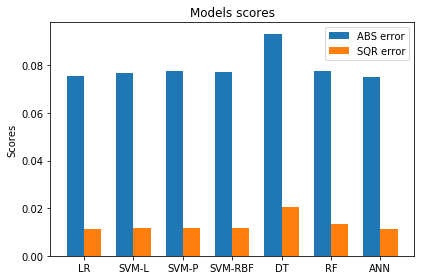

In [186]:
x = np.arange(len(Names))  
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Scores1, width, label='ABS error')
rects2 = ax.bar(x + width/2, Scores2, width, label='SQR error')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Models scores')
ax.set_xticks(x)
ax.set_xticklabels(Names)
ax.legend()
fig.tight_layout()

plt.show()

It is clear that the worst model is the Decision Tree Regression model: it has the biggest errors. The other models we tested have more or less the same errors, but none of them has very remarkable result. Therefore we can't say for sure which model is the best suited for our prediction. 

###IV. 2. Sentiment Prediction Models

In [0]:
Names2 = ['W2V-LGR', 'W2V-DTC', 'W2V-KNN','W2V-LDA', 'W2V-GNB', 'W2V-AC', 'NN' ]
Models2 =  [LGR_model, DTC_model, KNN_model, LDA_model, GNB_model, AC_model]
Scores22 = [round(model.score(X2_test, y2_test)*100, 2) for model in Models2] + [round(scores[1]*100, 2)]

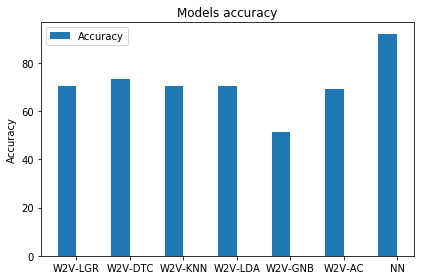

In [189]:
x2 = np.arange(len(Names2))  
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects12 = ax.bar(x2 - width/2, Scores22, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Models accuracy')
ax.set_xticks(x)
ax.set_xticklabels(Names2)
ax.legend()
fig.tight_layout()

plt.show()

As we have already seen, the best model is the *keras* neural network. 